# <center> Credit Card Fraud Detection: MODEL BUILDING </center>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


<b>Plan :</b>

- I - Resample & split data.
- II - First tests.
- III - Fine tuning.
- IV - Cross-validation.
- V - Final test.

<b>Choses à faire:</b>

- Ajouter barplot pour comparer les modèles.
- Expliquer pourquoi on undersample et oversample ( le papier).
- Expliquer pourquoi resample durant la cross validation.


In [3]:
df_origin_train =  pd.read_csv('/content/gdrive/MyDrive/DS_project/dataset/credit_card_fraud/train_set.csv')
df_test =  pd.read_csv('/content/gdrive/MyDrive/DS_project/dataset/credit_card_fraud/test_set.csv')

In [4]:
X_origin_train = df_origin_train.drop(columns=['Class'])
y_origin_train = df_origin_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [11]:
from sklearn.model_selection import train_test_split
# model
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, learning_curve

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

The challenge of working with Imbalanced datasets is that most ML techniques will ignore the minority class (or classes), and will in turn perform poorly on the minority class (or classes), although it is usually the performance on the minority class that is most important.

One approach to deal with unbalanced data sets is to oversample (oversample) the minority class(es):
- The simplest approach is to duplicate examples in the minority class, although these examples do not add any new information to the model.
- Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class(es) and is called Synthetic Minority Oversampling TEchnique, or SMOTE for short.


- How does SMOTE work?
    - SMOTE works by selecting examples that are close in variable space, drawing a line between the examples in variable space and drawing a new sample at a point along that line.
    - Specifically, a random example of the minority class is first selected. Then k of the closest neighbors is found. A randomly selected neighbor is chosen and a synthetic example is created at a point randomly selected between the two examples in the variable space.

- This procedure can be used to create as many synthetic examples for the minority class as necessary. As described in the paper below, it suggests using random undersampling first to reduce the number of examples in the majority class, and then using SMOTE to oversample the minority class to balance the class distribution.

- One could think that it is sufficient to perform these methods on the dataset once, before using it in our models. However, this is not what we are going to do, as this can cause a lot of problems, especially during validation. We will explain our methodology using SMOTE as we go along.

In [6]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)

X_train_resampled, y_train_resampled = over.fit_sample(X_origin_train, y_origin_train)
X_train_resampled, y_train_resampled = under.fit_sample(X_train_resampled, y_train_resampled)


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

#I - Test firsts model

In [ ]:
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBoost":XGBClassifier(),
    "LogisticRegression": LogisticRegression(),
    "Perceptron": Perceptron(),
    "KNN":KNeighborsClassifier()

}

In [ ]:
models = []
train_scores = []
valid_scores = []
valid_precision_scores = []
valid_recall_scores = []

In [ ]:
for key, classifier in classifiers.items():
    print('training with ' + key + ' ...')
   
    classifier.fit(X_train, y_train)
    
    models.append(key)
    train_scores.append(classifier.score(X_train, y_train))
    
    y_pred = classifier.predict(X_valid)

    valid_scores.append(accuracy_score(y_pred, y_valid))
    valid_precision_scores.append(precision_score(y_valid, y_pred))
    valid_recall_scores.append(recall_score(y_valid, y_pred))
    
    

training with RandomForest ...
training with DecisionTreeClassifier ...
training with XGBoost ...
training with LogisticRegression ...
training with Perceptron ...
training with KNN ...


In [ ]:
results = pd.DataFrame(data={'model':models, 'training score':train_scores,
                             'validation accuracy':valid_scores,
                             'validation precision':valid_precision_scores,
                            'validation recall':valid_recall_scores})
results

,model,training score,validation accuracy,validation precision,validation recall
0,RandomForest,1.000000,0.998805,0.998491,0.998260
1,DecisionTreeClassifier,1.000000,0.992831,0.987651,0.992923
2,XGBoost,0.963492,0.962361,0.977416,0.918900
3,LogisticRegression,0.938185,0.939359,0.964627,0.866922
4,Perceptron,0.908409,0.909956,0.838482,0.935375
5,KNN,0.996767,0.995391,0.987625,1.000000


- faire des barplots

# II - Fine Tuning.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:

params_classifiers = {
    "RandomForest": [{'n_estimators':[50, 100, 150],'max_depth':range(8, 15, 2 ),
               'max_features':['auto','sqrt','log2'], 'criterion':['gini','entropy']}],
    
    "DecisionTreeClassifier": [{'criterion':['gini','entropy'],'splitter':['best', 'random'],'max_depth':range(2, 20 ),
               'max_features':['auto','sqrt','log2']}],
    
    "LogisticRegression": [{'max_iter':range(100,800,100),'C': [ .01, .1, 1., 10., 100. ]}],
    "XGBoost": [{'max_depth': range(1,8,1),'n_estimators': [20, 60, 100, 150],
    'learning_rate': [0.005,0.025, 0.075, 0.25, 0.75]}],

    "Perceptron":[{'penalty':['l2','l1','elasticnet'], 'alpha':[.00001, .0001, .001, .01, .1], 'tol':[.0001, .001, .01]}],
                  
                  "KNN":[{'n_neighbors':range(2, 13), 'weights':['uniform', 'distance'],
                          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}]
    
}



In [ ]:
estimators = []
best_estimators = []
best_scores = []
for key, classifier in classifiers.items():
    print(key + ' tuning...')
    estimators.append(key)
    
    grid = GridSearchCV(classifier, params_classifiers[key],cv=3, scoring = 'balanced_accuracy', verbose=3, n_jobs=-1)
    grid.fit(X_train_resampled, y_train_resampled)
    
    best_estimators.append(grid.best_estimator_)
    best_scores.append(grid.best_score_)

RandomForest tuning...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 76.2min finished


DecisionTreeClassifier tuning...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  2.1min finished


XGBoost tuning...
Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 48.0min finished


LogisticRegression tuning...
Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   19.7s finished


Perceptron tuning...
Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   19.8s finished


KNN tuning...
Fitting 3 folds for each of 88 candidates, totalling 264 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 40.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 264 out of 264 | elapsed: 90.1min finished


In [ ]:
tuning = pd.DataFrame(data={'model':estimators, 'best estimator':best_estimators,
                             'best score':best_scores})
tuning

,model,best estimator,best score
0,RandomForest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.994752
1,DecisionTreeClassifier,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.991251
2,XGBoost,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.998418
3,LogisticRegression,"LogisticRegression(C=0.01, class_weight=None, ...",0.924025
4,Perceptron,"Perceptron(alpha=0.0001, class_weight=None, ea...",0.918072
5,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.998218


In [ ]:
print(best_estimators)

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=14, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=19, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), XGBClassifier(base_s

In [8]:
best_estimators = [RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=14, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=19, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.75, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='l2', random_state=0, shuffle=True, tol=0.01,
           validation_fraction=0.1, verbose=0, warm_start=False), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')]

#III - cross-validation

In [9]:
all_scores = []
for estim in best_estimators:
    pipeline = imbalanced_make_pipeline(over, under, estim)
    all_scores.append(cross_val_score(pipeline, X_origin_train.values, y_origin_train.values, cv=10, scoring='balanced_accuracy'))

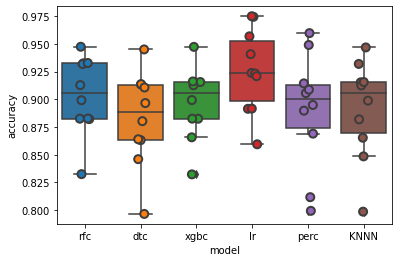

In [10]:
entries = []
models = ['rfc', 'dtc', 'xgbc', 'lr', 'perc', 'KNNN']
for i in range(0, len(all_scores)):
    for score in all_scores[i]:
        entries.append((models[i], score))
        
cv_df = pd.DataFrame(entries, columns=['model','accuracy'])

    
sns.boxplot(x='model', y='accuracy', data=cv_df)
sns.stripplot(x='model', y='accuracy', data=cv_df, 
                          size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

IV - testing

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.44      0.89      0.59        98

    accuracy                           1.00     56962
   macro avg       0.72      0.94      0.79     56962
weighted avg       1.00      1.00      1.00     56962

0.7184960707205672


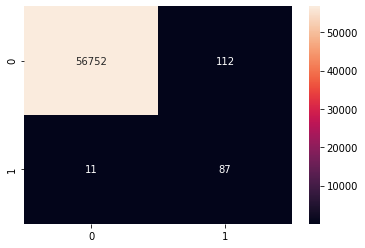

------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.81      0.26        98

    accuracy                           0.99     56962
   macro avg       0.58      0.90      0.63     56962
weighted avg       1.00      0.99      0.99     56962

0.5785169982485926


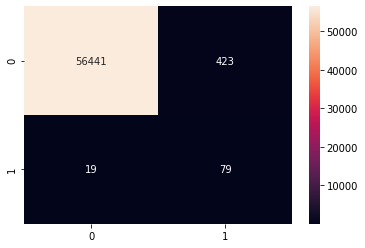

------------------------------
XGBClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.87      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.93      0.80     56962
weighted avg       1.00      1.00      1.00     56962

0.7346921549218715


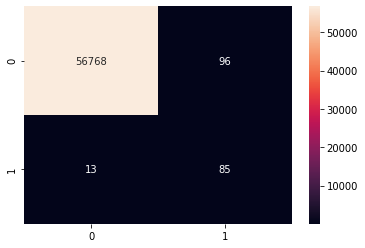

------------------------------
LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

0.5315958206806694


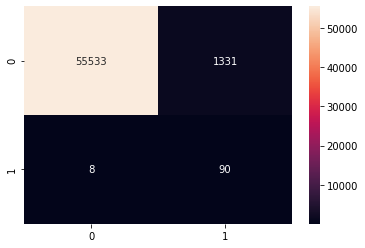

------------------------------
Perceptron
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56864
           1       0.02      0.91      0.04        98

    accuracy                           0.93     56962
   macro avg       0.51      0.92      0.50     56962
weighted avg       1.00      0.93      0.96     56962

0.5105939103240904


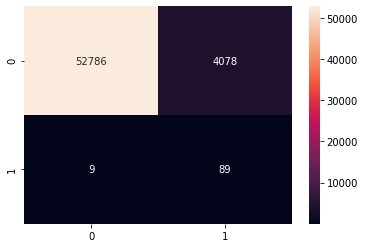

------------------------------
KNeighborsClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.80      0.52        98

    accuracy                           1.00     56962
   macro avg       0.69      0.90      0.76     56962
weighted avg       1.00      1.00      1.00     56962

0.6938536734414291


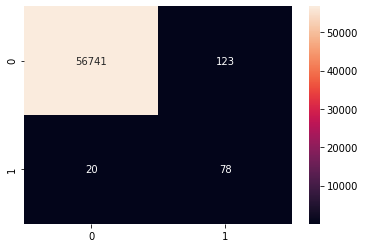

------------------------------


In [13]:

for estim in best_estimators:
    print(estim.__class__.__name__)
    pipeline = imbalanced_make_pipeline(over, under, estim)
    pipeline.fit(X_origin_train.values, y_origin_train.values)
    y_pred = pipeline.predict(X_test.values)
    print(classification_report(y_test.values, y_pred))
    print(balanced_accuracy_score(y_pred, y_test))
    conf = confusion_matrix(y_test.values, y_pred)
    sns.heatmap(conf,annot=True,fmt='2.0f')
    plt.show()
    print('-'*30)
    
    